# Virtuepot Log analysis


To access the log files, you can use the following link: https://archive.org/download/virtuepot

In [44]:
%pip install seaborn
import pandas as pd
import json
import gzip
import glob
import os
import seaborn as sb

%matplotlib inline
import matplotlib.pyplot as plt


%pip install folium

import requests
import folium
import json

import numpy as np

%pip install country_converter
import geopandas as gpd
import country_converter as coco

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [45]:
vsix_gn_df = pd.read_csv("./Greynoise/VSIX/gn_analysis_2024-01-05-1707_modbus.csv")
cloud_gn_df = pd.read_csv("./Greynoise/Cloud/gn_analysis_2024-01-05-1605_modbus.csv")
frames = [vsix_gn_df, cloud_gn_df]
df = pd.concat(frames)
print (df["classification"].unique())
df


['benign' 'malicious' 'unknown' 'RIOT']


,ip,classification,first_seen,last_seen,actor,spoofable,asn,category,country,country_code,...,city,organization,rdns,tor,os,tags,ja3,scans,paths,useragents
0,205.210.31.198,benign,2023-04-14,2024-01-05,Cortex Xpanse,False,AS396982,hosting,Brazil,BR,...,São Paulo,Google LLC,NaN,False,Linux 2.2.x-3.x (Embedded),Azure OMI RCE Attempt|Cisco Smart Install Endp...,19e29534fd49dd27d09234e639c4057e:80|795bc7ce13...,0/ICMP|20/TCP|21/TCP|22/TCP|23/TCP|53/UDP|67/T...,/|/wsman,"Expanse, a Palo Alto Networks company, searche..."
1,162.243.151.12,malicious,2019-04-04,2024-01-05,Stretchoid,False,AS14061,hosting,United States,US,...,San Francisco,"DigitalOcean, LLC",apzg-0727-m-190.stretchoid.com,False,Linux 3.11+,SSH Bruteforcer|SSH Worm|ZMap Client,NaN,20/TCP|21/UDP|22/TCP|23/TCP|25/UDP|26/TCP|53/T...,NaN,NaN
2,167.248.133.122,benign,2023-10-27,2024-01-05,Censys,False,AS398324,business,United States,US,...,Chicago,"Censys, Inc.",scanner-26.ch1.censys-scanner.com,False,Linux 2.2-3.x,Codesys Scanner|Erlang Port Mapper Daemon Craw...,1289771a3fce256d5fb4cb5c95b43ee6:1|1f24dbdea9c...,1/TCP|2/TCP|3/TCP|4/TCP|5/TCP|6/TCP|7/TCP|8/TC...,/api/v1/label/goversion/values|/api/v1/targets...,Mozilla/5.0 (compatible; CensysInspect/1.1; +h...
3,162.142.125.224,benign,2023-03-07,2024-01-05,Censys,False,AS398324,business,United States,US,...,Chicago,"Censys, Inc.",scanner-25.ch1.censys-scanner.com,False,Linux 2.2-3.x,Codesys Scanner|Erlang Port Mapper Daemon Craw...,1f24dbdea9cbd448a034e5d87c14168f:1|35fa0a83e46...,1/TCP|2/TCP|3/TCP|4/TCP|5/TCP|6/TCP|7/TCP|8/TC...,/version|/|/api/v1/label/goversion/values|/api...,Mozilla/5.0 (compatible; CensysInspect/1.1; +h...
4,167.94.146.52,benign,2023-08-23,2024-01-05,Censys,False,AS398705,business,Germany,DE,...,Frankfurt am Main,"Censys, Inc.",NaN,False,Linux 2.2-3.x,Codesys Scanner|Erlang Port Mapper Daemon Craw...,35fa0a83e466acbec1cfbb9016d550ab:1|35fa0a83e46...,1/TCP|2/TCP|3/TCP|4/TCP|5/TCP|6/TCP|7/TCP|8/TC...,/api/v1/label/goversion/values|/api/v1/label/v...,Mozilla/5.0 (compatible; CensysInspect/1.1; +h...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,167.94.146.55,benign,2023-07-28,2024-01-05,Censys,False,AS398705,business,Germany,DE,...,Frankfurt am Main,"Censys, Inc.",NaN,False,Linux 2.2-3.x,Censys|Codesys Scanner|Erlang Port Mapper Daem...,35fa0a83e466acbec1cfbb9016d550ab:1|35fa0a83e46...,1/TCP|2/TCP|3/TCP|4/TCP|5/TCP|6/TCP|7/TCP|8/TC...,/api/v1/query|/api/v1/label/version/values|/ap...,Mozilla/5.0 (compatible; CensysInspect/1.1; +h...
76,172.105.128.11,benign,2022-08-25,2024-01-05,bufferover.run,False,AS63949,hosting,United States,US,...,Morris Plains,Akamai Connected Cloud,oslo.scan.bufferover.run,False,unknown,SSH Bruteforcer|SSH Worm|Telnet Bruteforcer|TL...,c3a6cf0bf2e690ac8e1ecf6081f17a50:1|cba7f34191e...,1/TCP|7/TCP|9/TCP|13/TCP|21/TCP|22/TCP|23/TCP|...,/,Mozilla/5.0 (Macintosh; Intel Mac OS X 13_1) A...
77,65.49.1.108,malicious,2023-07-07,2024-01-05,unknown,False,AS6939,hosting,United States,US,...,Pleasanton,Hurricane Electric LLC,scan-59a.shadowserver.org,False,Linux 2.2.x-3.x (Embedded),ADB Check|Cisco Implant Trigger Packet|Cisco S...,cba7f34191ef2379c1325641f6c6c4f4:80|22aa2bdb63...,7/UDP|17/UDP|19/UDP|21/TCP|22/TCP|23/TCP|25/TC...,/api/v2/static/not.found|/|/geoserver/web/|/fa...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...
78,198.74.56.46,malicious,2022-12-05,2024-01-05,unknown,False,AS63949,hosting,United States,US,...,Morris Plains,Akamai Connected Cloud,198-74-56-46.ip.linodeusercontent.com,False,Linux 2.2.x-3.x (Embedded),MQTT Protocol Scanner|RDP Alternative Port Cra...,cba7f34191ef2379c1325641f6c6c4f4:23|cba7f34191...,1/TCP|7/TCP|9/TCP|13/TCP|21/TCP|22/TCP|23/TCP|...,/,Mozilla/5.0 zgrab/0.x|


In [46]:
vsix_df_un = vsix_gn_df.drop_duplicates(subset='ip', keep='first')
print ("VSIX Malicious IPs percentage: " +str(100*len(vsix_df_un[vsix_df_un["classification"] == "malicious"])/len(vsix_df_un)))
print ("VSIX Benign IPs percentage: " +str(100*len(vsix_df_un[vsix_df_un["classification"] == "benign"])/len(vsix_df_un)))



cloud_df_un = cloud_gn_df.drop_duplicates(subset='ip', keep='first')
print ("Cloud Malicious IPs percentage: " +str(100*len(cloud_df_un[cloud_df_un["classification"] == "malicious"])/len(cloud_df_un)))
print ("Cloud Benign IPs percentage: " +str(100*len(cloud_df_un[cloud_df_un["classification"] == "benign"])/len(cloud_df_un)))

VSIX Malicious IPs percentage: 38.05309734513274
VSIX Benign IPs percentage: 57.52212389380531
Cloud Malicious IPs percentage: 40.0
Cloud Benign IPs percentage: 58.75


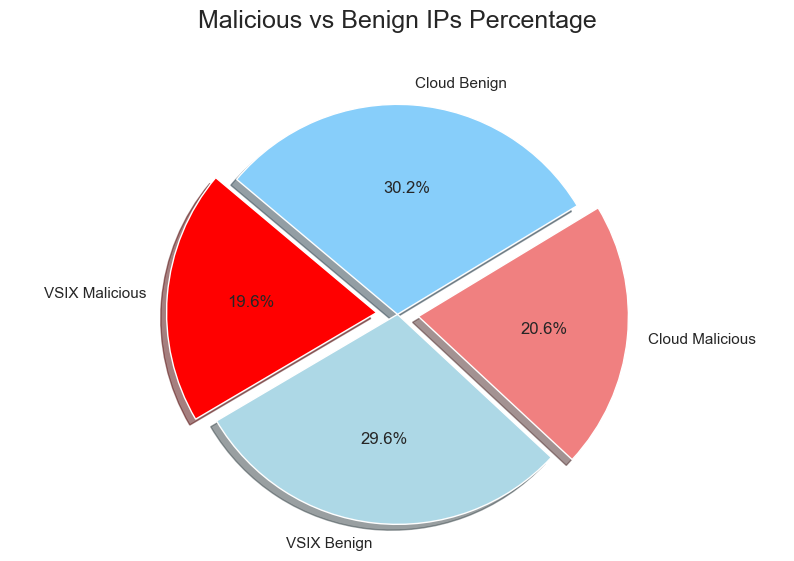

In [47]:
# VSIX Data
vsix_df_un = vsix_gn_df.drop_duplicates(subset='ip', keep='first')
vsix_malicious_percentage = 100 * len(vsix_df_un[vsix_df_un["classification"] == "malicious"]) / len(vsix_df_un)
vsix_benign_percentage = 100 * len(vsix_df_un[vsix_df_un["classification"] == "benign"]) / len(vsix_df_un)

# Cloud Data
cloud_df_un = cloud_gn_df.drop_duplicates(subset='ip', keep='first')
cloud_malicious_percentage = 100 * len(cloud_df_un[cloud_df_un["classification"] == "malicious"]) / len(cloud_df_un)
cloud_benign_percentage = 100 * len(cloud_df_un[cloud_df_un["classification"] == "benign"]) / len(cloud_df_un)

# Plotting Pie Chart
labels = ['VSIX Malicious', 'VSIX Benign', 'Cloud Malicious', 'Cloud Benign']
sizes = [vsix_malicious_percentage, vsix_benign_percentage, cloud_malicious_percentage, cloud_benign_percentage]
colors = ['red', 'lightblue', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0.1, 0)  # explode the 1st and 3rd slices

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Malicious vs Benign IPs Percentage', size=18,pad=40)
plt.savefig('MaliciousvsBenign.pdf',bbox_inches='tight')
plt.show()

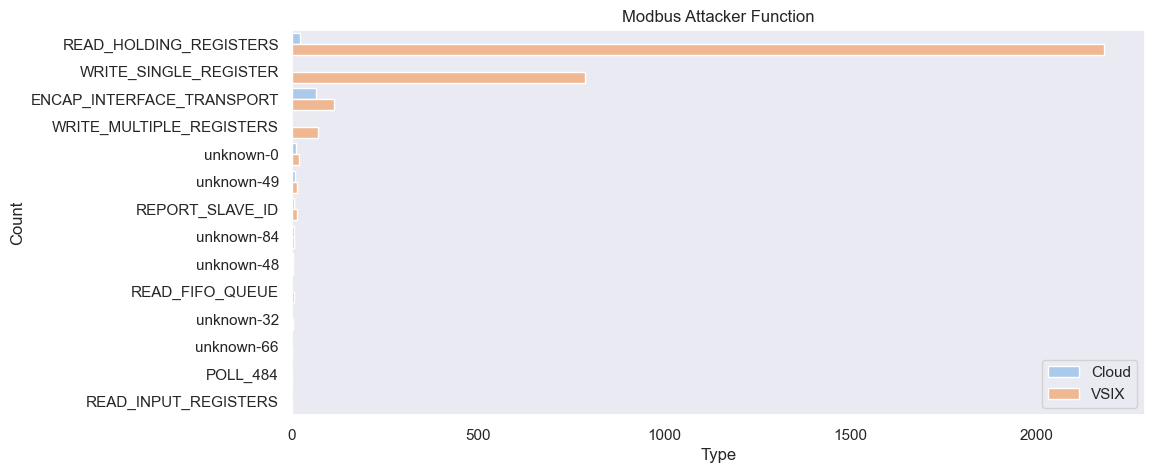

In [48]:
                      
#modbus
cloud_modbus_log_path = './Cloud/zeek_pcap/data/modbus_detailed.log'
vsix_modbus_log_path = './VSIX/zeek_pcap/modbus_detailed.log'

cloud_modbus_df = pd.read_json(cloud_modbus_log_path)
vsix_modbus_df = pd.read_json(vsix_modbus_log_path)

cloud_modbus_df['source'] = 'Cloud'
vsix_modbus_df['source'] = 'VSIX'
combined_df = pd.concat([cloud_modbus_df, vsix_modbus_df]) 

plt.figure(figsize=(11,5))

sb.countplot(data=combined_df, y='func', hue='source',
             order=combined_df['func'].value_counts().iloc[:20].index, orient='h',palette='pastel')
plt.legend(loc='lower right')
plt.title('Modbus Attacker Function')
plt.ylabel('Count')
plt.xlabel('Type');
plt.savefig('Modbus.pdf',bbox_inches='tight')

/var/folders/jb/hcx17ph52494vkhfp76frhg40000gn/T/ipykernel_17904/3825726360.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=25, horizontalalignment='right')


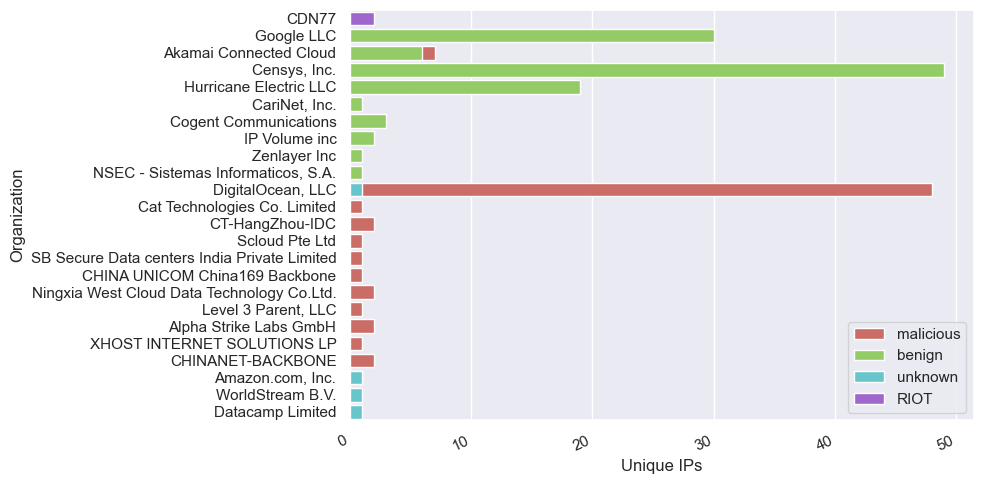

In [49]:
sb.set(rc={'figure.figsize':(10,5)})

df3 = df.groupby(["organization"])["classification"].value_counts().reset_index()
# selected_orga = ["DigitalOcean", "Amazon", "CHINA UNICOM", "Aggros Operations", "HK Zhengxing Technology" ]

g = sb.barplot(
    data=df3,palette = 'hls',
    y="organization", x="count", hue="classification", dodge=False,order=df.sort_values('classification',ascending = True).organization
)

g.set_xticklabels(g.get_xticklabels(), rotation=25, horizontalalignment='right')

# set labels
plt.xlabel("Unique IPs")
plt.ylabel("Organization")
plt.legend(loc='lower right')
#plt.title("", size=18)
plt.tight_layout()
plt.savefig('organization_stacked.pdf')

Indian Ocean Territories not found in regex
Ashmore and Cartier Islands not found in regex
Siachen Glacier not found in regex


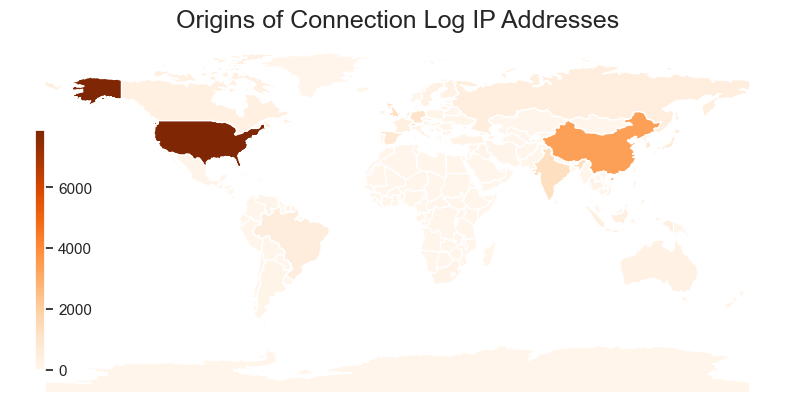

In [50]:

ip_list_cloud = pd.read_csv("./Cloud/results_iplist_cloud.csv")
ip_list_vsix = pd.read_csv("./VSIX/results_iplist_vsix.csv")

frames = [ip_list_cloud, ip_list_vsix ]

result = pd.concat(frames)

# Setting the path to the shapefile
SHAPEFILE = './worldmap/ne_50m_admin_0_countries.shp'

# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns.
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df.head(3)


# Next, we need to ensure that our data matches with the country codes.
iso3_codes = geo_df['country'].to_list()
# Convert to iso3_codes
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
# Add the list with iso2 codes to the dataframe
geo_df['iso2_code'] = iso2_codes_list
# There are some countries for which the converter could not find a country code.
# We will drop these countries.
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)
geo_df.head(3)


df1 = result.groupby(["country"]).size().reset_index(name='frequency')
# Merge the two dataframes
merged_df = pd.merge(left=geo_df, right=df1, how='left', left_on='iso2_code', right_on='country')
#Create the indicator values
merged_df['frequency'].fillna(0, inplace=True)
merged_df.head(3)



# Show the data
# Plot the map
title = "Origins of Connection Log IP Addresses"
col = 'frequency'
vmin = merged_df[col].min()
vmax = merged_df[col].max()
cmap = 'Oranges'

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
merged_df.plot(column=col, ax=ax, linewidth=1, cmap=cmap, edgecolor='white')
ax.set_title(title, fontdict={'fontsize': '18', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
fig.savefig('world_cloud&vsix.pdf', bbox_inches = 'tight', pad_inches = 0)

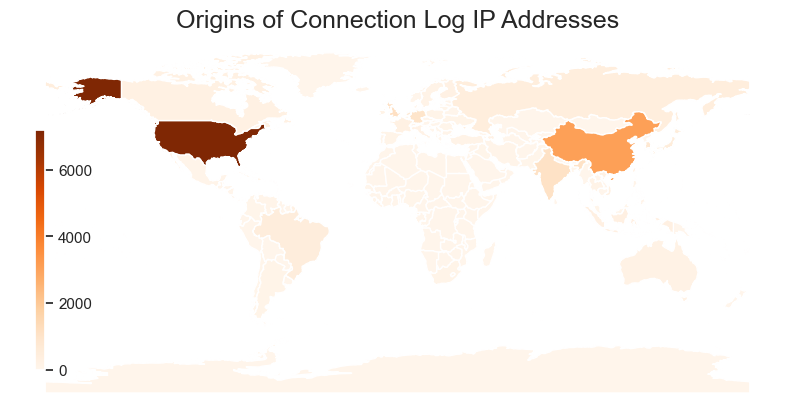

In [51]:
df1 = ip_list_cloud.groupby(["country"]).size().reset_index(name='frequency')
# Merge the two dataframes
merged_df = pd.merge(left=geo_df, right=df1, how='left', left_on='iso2_code', right_on='country')
#Create the indicator values
merged_df['frequency'].fillna(0, inplace=True)
merged_df.head(3)



# Show the data
# Plot the map
title = "Origins of Connection Log IP Addresses"
col = 'frequency'
vmin = merged_df[col].min()
vmax = merged_df[col].max()
cmap = 'Oranges'

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
merged_df.plot(column=col, ax=ax, linewidth=1, cmap=cmap, edgecolor='white')
ax.set_title(title, fontdict={'fontsize': '18', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
fig.savefig('world_cloud.pdf', bbox_inches = 'tight', pad_inches = 0)

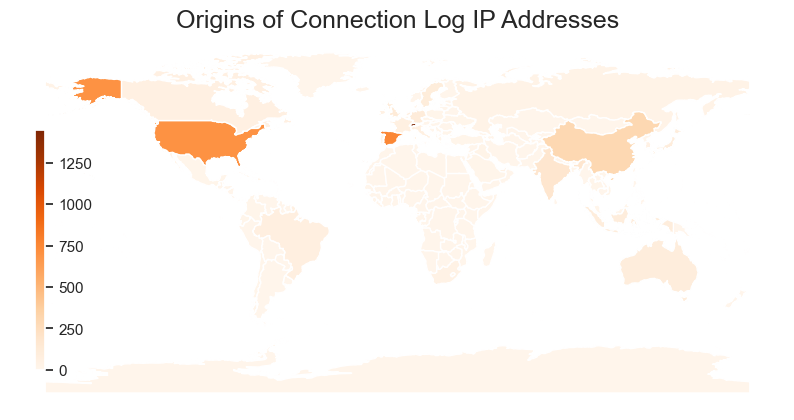

In [52]:
df1 = ip_list_vsix.groupby(["country"]).size().reset_index(name='frequency')
# Merge the two dataframes
merged_df = pd.merge(left=geo_df, right=df1, how='left', left_on='iso2_code', right_on='country')
#Create the indicator values
merged_df['frequency'].fillna(0, inplace=True)
merged_df.head(3)



# Show the data
# Plot the map
title = "Origins of Connection Log IP Addresses"
col = 'frequency'
vmin = merged_df[col].min()
vmax = merged_df[col].max()
cmap = 'Oranges'

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
merged_df.plot(column=col, ax=ax, linewidth=1, cmap=cmap, edgecolor='white')
ax.set_title(title, fontdict={'fontsize': '18', 'fontweight' : '3'})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
fig.savefig('world_vsix.pdf', bbox_inches = 'tight', pad_inches = 0)

In [53]:
sb.set(rc={'figure.figsize':(6,4)})
df1 = vsix_gn_df.groupby(["country"]).size().reset_index(name='frequency')
vsix_top_contry = df1.sort_values('frequency',ascending = False)
print (vsix_top_contry)

           country  frequency
11   United States         71
5          Germany         11
2           Brazil          7
3            China          5
7      Netherlands          5
9           Taiwan          5
1          Belgium          2
0          Austria          1
4         Colombia          1
6            India          1
8           Russia          1
10  United Kingdom          1


In [54]:
sb.set(rc={'figure.figsize':(6,4)})
df1 = cloud_gn_df.groupby(["country"]).size().reset_index(name='frequency')
cloud_top_contry = df1.sort_values('frequency',ascending = False)
print (cloud_top_contry)

          country  frequency
9   United States         57
3         Germany          9
1          Brazil          4
0         Belgium          3
2           China          2
4       Hong Kong          1
5     Netherlands          1
6          Russia          1
7          Taiwan          1
8  United Kingdom          1


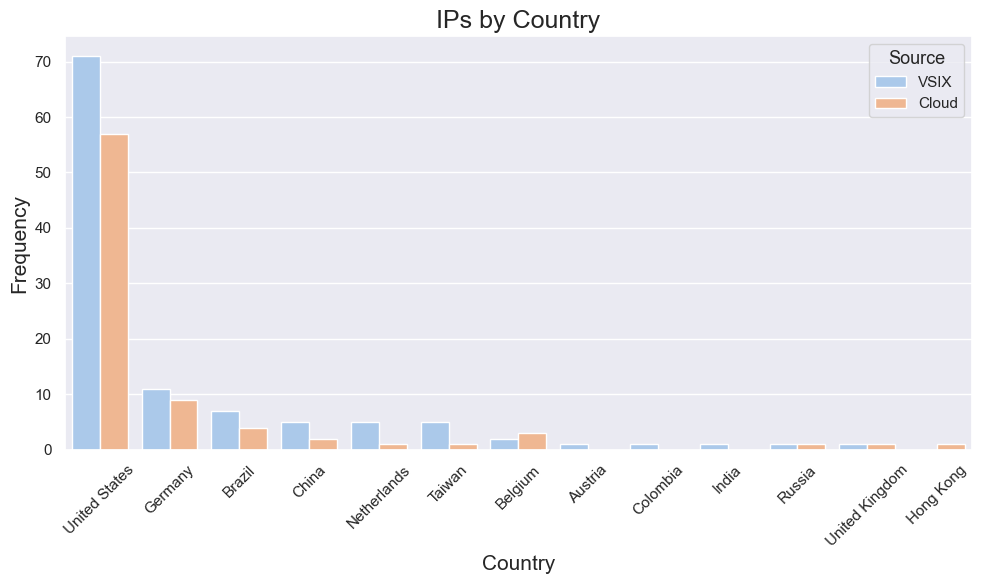

In [55]:
# Adding a 'source' column to identify the source of each data frame
vsix_top_contry['source'] = 'VSIX'
cloud_top_contry['source'] = 'Cloud'

# Concatenating both data frames
combined_df = pd.concat([vsix_top_contry, cloud_top_contry], ignore_index=True)

# Plotting the bar chart
sb.set(rc={'figure.figsize': (10, 6)})
g = sb.barplot(x='country', y='frequency', hue='source', data=combined_df, palette='pastel')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel("Country", size=15)
plt.ylabel("Frequency", size=15)
plt.title("IPs by Country", size=18)

# Displaying the legend outside the plot
plt.legend(title='Source', title_fontsize='13', fontsize='11', loc='upper right')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('countries_comparison.pdf')

# Show plot
plt.show()

                                    organization  frequency
7                              DigitalOcean, LLC         48
0                         Akamai Connected Cloud          7
8                         Hurricane Electric LLC          5
1                         Alpha Strike Labs GmbH          2
4                              CHINANET-BACKBONE          2
5                                CT-HangZhou-IDC          2
10    Ningxia West Cloud Data Technology Co.Ltd.          2
2                               Amazon.com, Inc.          1
3                 CHINA UNICOM China169 Backbone          1
6                   Cat Technologies Co. Limited          1
9                            Level 3 Parent, LLC          1
11  SB Secure Data centers India Private Limited          1
12                                Scloud Pte Ltd          1
13                   XHOST INTERNET SOLUTIONS LP          1


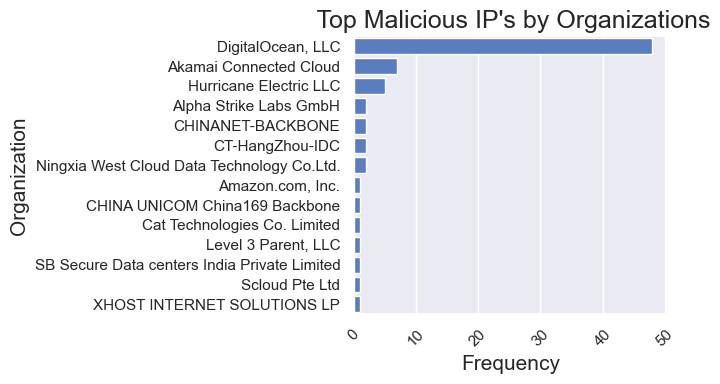

In [56]:
# country counter
sb.set(rc={'figure.figsize':(7,4)})
df2 = df[df["classification"] == 'malicious']
df2 = df2.groupby(["organization"]).size().reset_index(name='frequency')
sb.set_color_codes("muted")
g = sb.barplot(y='organization',  x="frequency", data=df2, order=df2.sort_values('frequency',ascending = False).organization, color='b')
print (df2.sort_values('frequency',ascending = False))
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

# set labels
plt.xlabel("Frequency", size=15)
plt.ylabel("Organization", size=15)
plt.title(" Top Malicious IP's by Organizations", size=18)
plt.tight_layout()
plt.savefig('organizations.pdf')

In [57]:
cloud_http_log_path = './Cloud/zeek_pcap/data/http.log'
vsix_http_log_path = './VSIX/zeek_pcap/http.log'
cloud_http_df = pd.read_json(cloud_http_log_path)
vsix_http_df = pd.read_json(vsix_http_log_path)

In [58]:
print("Number of unique ip address Modbus VSIX",vsix_gn_df["ip"].nunique())
print("Number of unique ip address Modbus Cloud",cloud_gn_df["ip"].nunique())
print("Number of unique ip address Conn VSIX",ip_list_vsix["ip"].nunique())
print("Number of unique ip address Conn Cloud",ip_list_cloud["ip"].nunique())
print("Number of unique ip address HTTP VSIX",vsix_http_df["id.orig_h"].nunique())
print("Number of unique ip address HTTP Cloud",cloud_http_df["id.orig_h"].nunique())

Number of unique ip address Modbus VSIX 113
Number of unique ip address Modbus Cloud 80
Number of unique ip address Conn VSIX 5040
Number of unique ip address Conn Cloud 22417
Number of unique ip address HTTP VSIX 941
Number of unique ip address HTTP Cloud 804


In [59]:
cloud_get_count = cloud_http_df['method'].value_counts()
vsix_get_count = vsix_http_df['method'].value_counts()

print(cloud_get_count)
print(vsix_get_count)

method
GET        2715
HEAD        376
POST        328
CONNECT     279
PRI          37
OPTIONS      15
t3            4
DELETE        2
HI            2
Name: count, dtype: int64
method
GET        21716
CONNECT     1013
PRI           64
POST          63
OPTIONS       16
HEAD          16
t3             3
PUT            2
HI             2
fox            1
USER           1
Name: count, dtype: int64


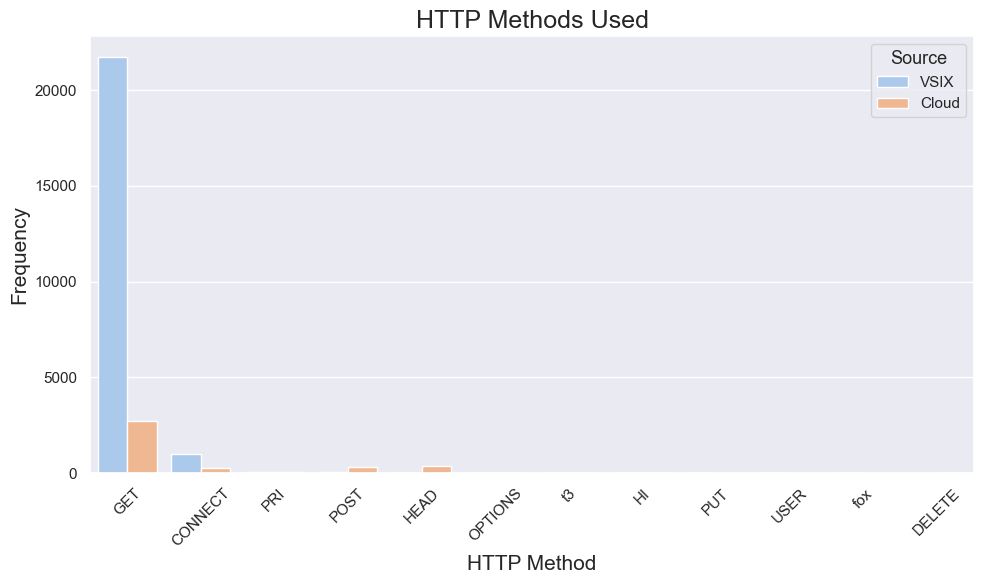

In [60]:


df1 = cloud_http_df.groupby(["method"]).size().reset_index(name='frequency')
cloud_get_contry = df1.sort_values('frequency',ascending = False)
df2 = vsix_http_df.groupby(["method"]).size().reset_index(name='frequency')
vsix_get_contry = df2.sort_values('frequency',ascending = False)



# Adding a 'source' column to identify the source of each data frame
vsix_get_contry['source'] = 'VSIX'
cloud_get_contry['source'] = 'Cloud'

# Concatenating both data frames
combined_df = pd.concat([vsix_get_contry, cloud_get_contry], ignore_index=True)

# Plotting the bar chart
sb.set(rc={'figure.figsize': (10, 6)})
g = sb.barplot(x='method', y='frequency', hue='source', data=combined_df,palette='pastel')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel("HTTP Method", size=15)
plt.ylabel("Frequency", size=15)
plt.title("HTTP Methods Used", size=18)

# Displaying the legend outside the plot
plt.legend(title='Source', title_fontsize='13', fontsize='11', loc='upper right')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('http_methods.pdf')

# Show plot
plt.show()


/var/folders/jb/hcx17ph52494vkhfp76frhg40000gn/T/ipykernel_17904/363598593.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  cloud_conn_df = pd.read_csv("./Cloud/cloud_conn_df.csv")
/var/folders/jb/hcx17ph52494vkhfp76frhg40000gn/T/ipykernel_17904/363598593.py:2: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  vsix_conn_df = pd.read_csv("./VSIX/vsix_conn_df.csv")


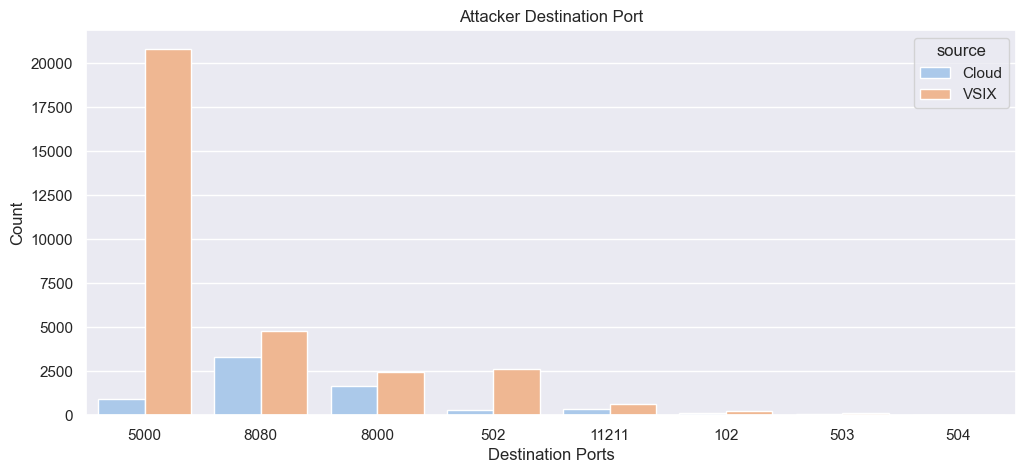

In [61]:
cloud_conn_df = pd.read_csv("./Cloud/cloud_conn_df.csv")
vsix_conn_df = pd.read_csv("./VSIX/vsix_conn_df.csv")

cloud_conn_df =cloud_conn_df.rename(columns={'id.resp_p': 'resp_p',})
vsix_conn_df =vsix_conn_df.rename(columns={'id.resp_p': 'resp_p',})


# Filter the dataframes to include only the specified resp_p values
resp_p_values = [502,503,504,102,11211,5000,8080,8000]
cloud_conn_df = cloud_conn_df[cloud_conn_df['resp_p'].isin(resp_p_values)]
vsix_conn_df = vsix_conn_df[vsix_conn_df['resp_p'].isin(resp_p_values)]


cloud_conn_df['source'] = 'Cloud'
vsix_conn_df['source'] = 'VSIX'
combined_df = pd.concat([cloud_conn_df, vsix_conn_df]) 

plt.figure(figsize=(12,5))

sb.countplot(data=combined_df, x='resp_p', hue='source',
             order=combined_df['resp_p'].value_counts().index, orient='h',palette='pastel')
sb.set_style("dark")
plt.title('Attacker Destination Port')
plt.ylabel('Count')
plt.xlabel('Destination Ports');
plt.savefig('dest_ports.pdf')